In [30]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from scipy import stats
import seaborn as sns
import talib as ta
from talib import RSI, BBANDS, MACD, ATR, MA, PPO
import warnings
from typing import List
import statsmodels.api as sm
from scipy.stats import spearmanr
import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
matplotlib.rcParams['figure.figsize'] = (15, 10)
warnings.filterwarnings('ignore')

# Read Data

In [2]:
try:
    os.chdir("../DataBase/files")
except FileNotFoundError:
    pass
!ls -a

.
..
.DS_Store
Archive
price_execution_data_list_16-08-2022-13-24-21.json
price_execution_data_list_16-08-2022-15-32-04.json
trade_book_data_16-08-2022-13-24-21.json
trade_book_data_16-08-2022-15-32-04.json


In [3]:
file_name = "price_execution_data_list"

def read_data_files(name_like: str):
    data_dict = {}
    for file_name in os.listdir():
        if name_like in file_name:
            data_dict[file_name] = pd.read_json(file_name)
    return data_dict

def aggregate_dict_to_dataframe(dictinary):
    df = pd.DataFrame()
    for key, val in dictinary.items():
        df = pd.concat([df, dictinary[key]], axis = 0)
    df.set_index("time", inplace=True)
    return df

price_execution_data = read_data_files(file_name)
price_execution_data_df = aggregate_dict_to_dataframe(price_execution_data)


del price_execution_data

price_execution_data_df = price_execution_data_df.sort_index()

In [4]:
price_execution_data_df.head()

,symbol,price,delta_time
time,,,
1.660649e+09,BTCUSDT,24071.72,1.332418
1.660649e+09,BTCUSDT,24071.40,0.611654
1.660649e+09,BTCUSDT,24072.47,1.330175
1.660649e+09,BTCUSDT,24073.85,0.592218
1.660649e+09,BTCUSDT,24072.48,0.634877


In [5]:
price_execution_data_df["return"] = price_execution_data_df.price.pct_change()

In [6]:
price_execution_data_df["price_forward"] = price_execution_data_df.price.shift(-13)
price_execution_data_df["return_forward"] = price_execution_data_df.price.pct_change().shift(-13)
price_execution_data_df.dropna(inplace=True)

train_size = int(0.7*price_execution_data_df.shape[0])
price_execution_data_df.reset_index(inplace=True)
data_train, data_test = price_execution_data_df.iloc[:train_size], price_execution_data_df.iloc[train_size:]

print(data_train.shape)
print(data_test.shape)

(13990, 7)
(5996, 7)


In [7]:
data_train.head()

,time,symbol,price,delta_time,return,price_forward,return_forward
0,1.660649e+09,BTCUSDT,24071.40,0.611654,-0.000013,24076.39,-0.000010
1,1.660649e+09,BTCUSDT,24072.47,1.330175,0.000044,24076.43,0.000002
2,1.660649e+09,BTCUSDT,24073.85,0.592218,0.000057,24077.94,0.000063
3,1.660649e+09,BTCUSDT,24072.48,0.634877,-0.000057,24077.11,-0.000034
4,1.660649e+09,BTCUSDT,24073.51,0.613495,0.000043,24076.65,-0.000019


# Feature Engineering

## Shifted Returns

In [9]:
def create_shift_price(series: pd.Series, shift_val):
    return series.shift(shift_val)

In [10]:
data_train[f"return{1}_back"] = create_shift_price(data_train["return"], 0)
for i in range(1,6):
    data_train[f"return{13*i}_back"] = create_shift_price(data_train["return"], 13*i)
    data_test[f"return{13*i}_back"] = create_shift_price(data_test["return"], 13*i)

## Moving Average Returns

In [11]:
for i in range(1,6):
    data_train[f"MA_{13*i}_returns"] = MA(data_train["price"], 13*i).pct_change()
    data_test[f"MA_{13*i}_returns"] = MA(data_test["price"], 13*i).pct_change()

## RSI

In [12]:
data_train["RSI"] = RSI(data_train["price"])
data_test["RSI"] = RSI(data_test["price"])

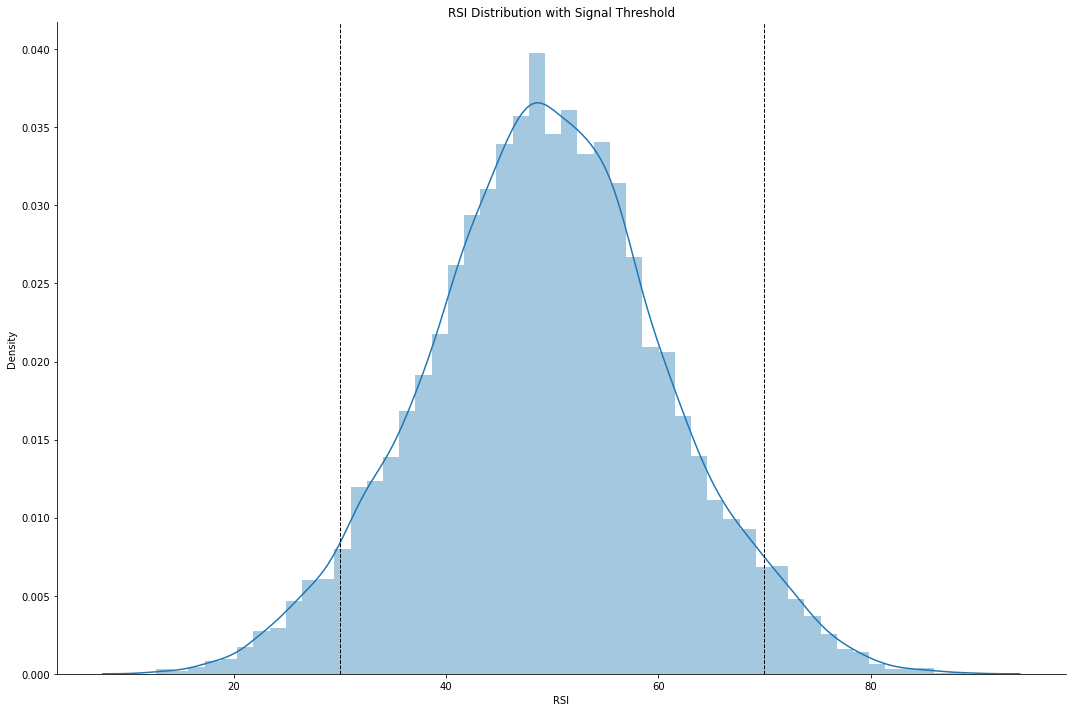

In [13]:
ax = sns.distplot(data_train["RSI"].dropna())
ax.axvline(30, ls='--', lw=1, c='k')
ax.axvline(70, ls='--', lw=1, c='k')
ax.set_title('RSI Distribution with Signal Threshold')
sns.despine()
plt.tight_layout();

## Bolinger Bands on Returns

In [14]:
high, mid, low = BBANDS(data_train["price"], timeperiod=13)

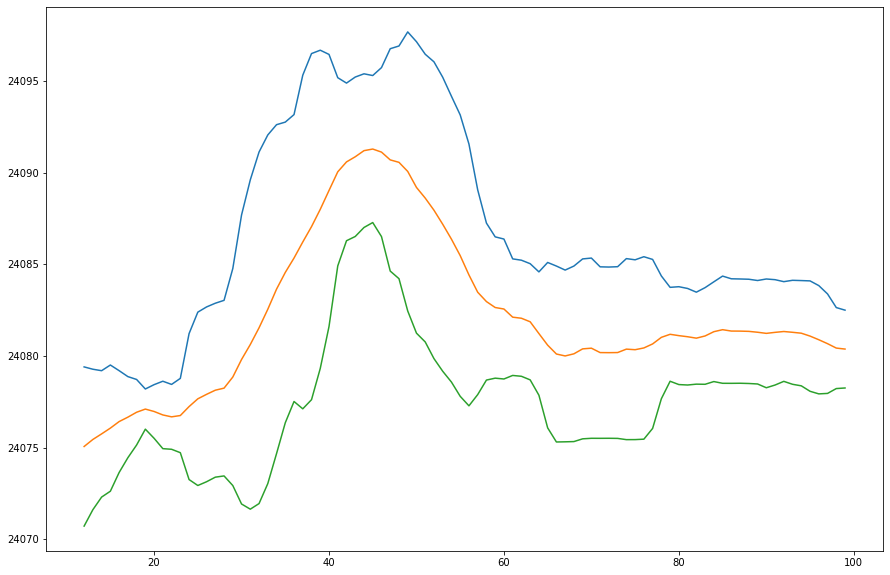

In [15]:
plt.plot(high[:100])
plt.plot(mid[:100])
plt.plot(low[:100])

In [16]:
for i in range(1,6):
    high, mid, low = BBANDS(data_train["price"], timeperiod=13*i)
    data_train[f"BB_high_{13*i}_returns"] = high.pct_change()
    data_train[f"BB_low_{13*i}_returns"] = low.pct_change()
    
    high, mid, low = BBANDS(data_test["price"], timeperiod=13*i)
    data_test[f"BB_high_{13*i}_returns"] = high.pct_change()
    data_test[f"BB_low_{13*i}_returns"] = low.pct_change()

## Moving Average Convergence/Divergence

In [17]:
data_train["PPO"] = PPO(data_train["price"])
data_test["PPO"] = PPO(data_test["price"])

<AxesSubplot:>

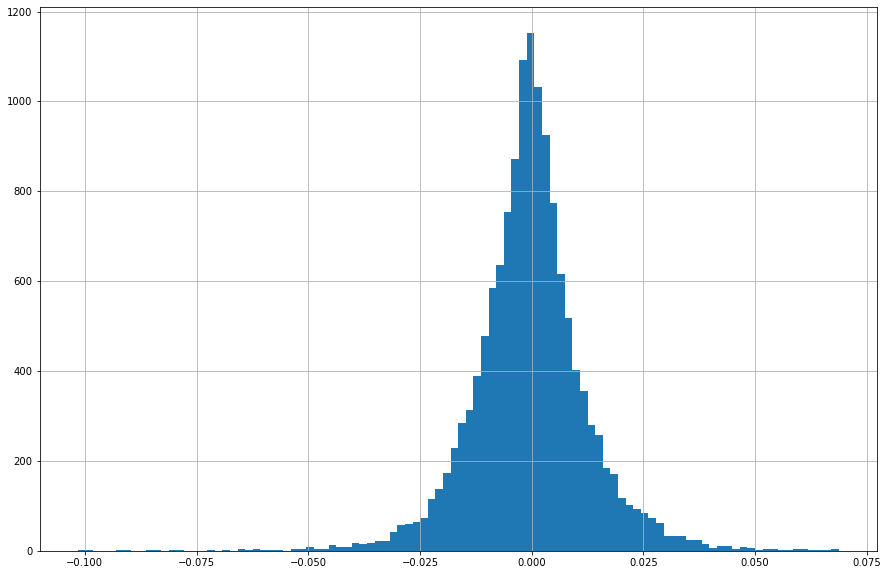

In [18]:
data_train["PPO"].hist(bins = 100)

In [19]:
def compute_macd(price):
    macd = MACD(price)[0]
    return (macd - np.mean(macd))/np.std(macd)
data_train["MACD"] = compute_macd(data_train["price"])
data_test["MACD"] = compute_macd(data_test["price"])

## Compute rolling quantiles

In [20]:
def compute_quantile(series, quantile_val):
    return series.quantile(quantile_val)

In [21]:
low_quantile = 0.01
high_quantile = 0.99
for i in range(1,5):
    data_train[f"quantile_{i*13}_{low_quantile}"] = data_train["return"].rolling(i*13).apply(lambda x: compute_quantile(x, low_quantile))
    data_train[f"quantile_{i*13}_{high_quantile}"] = data_train["return"].rolling(i*13).apply(lambda x: compute_quantile(x, high_quantile))
    
    data_test[f"quantile_{i*13}_{low_quantile}"] = data_test["return"].rolling(i*13).apply(lambda x: compute_quantile(x, low_quantile))
    data_test[f"quantile_{i*13}_{high_quantile}"] = data_test["return"].rolling(i*13).apply(lambda x: compute_quantile(x, high_quantile))

## Compute rolling volatility

In [22]:
def compute_vol(series):
    return series.std()

In [23]:
for i in range(1,5):
    data_train[f"vol_{i*13}"] = data_train["return"].rolling(i*13).apply(lambda x: compute_vol(x))
    data_test[f"vol_{i*13}"] = data_test["return"].rolling(i*13).apply(lambda x: compute_vol(x))

# Train Test Data

In [24]:
data_train = data_train.dropna()
data_test = data_test.dropna()

data_train.index = data_train.time
data_test.index = data_test.time

In [25]:
feature_name = list(data_train.columns[7:])
target = [data_train.columns[6]]
print(target)
print(feature_name)

['return_forward']
['return1_back', 'return13_back', 'return26_back', 'return39_back', 'return52_back', 'return65_back', 'MA_13_returns', 'MA_26_returns', 'MA_39_returns', 'MA_52_returns', 'MA_65_returns', 'RSI', 'BB_high_13_returns', 'BB_low_13_returns', 'BB_high_26_returns', 'BB_low_26_returns', 'BB_high_39_returns', 'BB_low_39_returns', 'BB_high_52_returns', 'BB_low_52_returns', 'BB_high_65_returns', 'BB_low_65_returns', 'PPO', 'MACD', 'quantile_13_0.01', 'quantile_13_0.99', 'quantile_26_0.01', 'quantile_26_0.99', 'quantile_39_0.01', 'quantile_39_0.99', 'quantile_52_0.01', 'quantile_52_0.99', 'vol_13', 'vol_26', 'vol_39', 'vol_52']


# Data Visualisation

## Descriptive Statistics

In [26]:
data_train[feature_name].describe()

,return1_back,return13_back,return26_back,return39_back,return52_back,return65_back,MA_13_returns,MA_26_returns,MA_39_returns,MA_52_returns,...,quantile_26_0.01,quantile_26_0.99,quantile_39_0.01,quantile_39_0.99,quantile_52_0.01,quantile_52_0.99,vol_13,vol_26,vol_39,vol_52
count,1.392500e+04,1.392500e+04,1.392500e+04,1.392500e+04,1.392500e+04,1.392500e+04,1.392500e+04,1.392500e+04,1.392500e+04,1.392500e+04,...,13925.000000,13925.000000,13925.000000,13925.000000,13925.000000,13925.000000,13925.000000,13925.000000,13925.000000,13925.000000
mean,-5.708337e-07,-5.994318e-07,-6.116267e-07,-5.737586e-07,-6.166934e-07,-6.225414e-07,-5.881607e-07,-5.989614e-07,-5.931647e-07,-5.900062e-07,...,-0.000161,0.000157,-0.000177,0.000172,-0.000186,0.000181,0.000075,0.000077,0.000078,0.000078
std,8.398301e-05,8.398939e-05,8.398937e-05,8.387857e-05,8.384198e-05,8.380099e-05,2.254616e-05,1.549123e-05,1.207670e-05,1.020445e-05,...,0.000102,0.000074,0.000104,0.000073,0.000103,0.000071,0.000038,0.000034,0.000032,0.000031
min,-1.171671e-03,-1.171671e-03,-1.171671e-03,-1.171671e-03,-1.171671e-03,-1.171671e-03,-1.664296e-04,-9.757303e-05,-6.799223e-05,-5.359188e-05,...,-0.001030,0.000029,-0.000986,0.000034,-0.000941,0.000050,0.000013,0.000018,0.000021,0.000026
25%,-3.988553e-05,-3.990848e-05,-3.990848e-05,-3.989266e-05,-3.992403e-05,-3.990848e-05,-1.206611e-05,-8.715554e-06,-6.872283e-06,-5.969398e-06,...,-0.000193,0.000102,-0.000215,0.000118,-0.000225,0.000128,0.000050,0.000054,0.000055,0.000056
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-7.351668e-07,-7.195270e-07,-5.986840e-07,-4.981117e-07,...,-0.000142,0.000142,-0.000154,0.000161,-0.000162,0.000173,0.000067,0.000070,0.000071,0.000071
75%,3.784734e-05,3.772078e-05,3.771712e-05,3.767308e-05,3.761752e-05,3.761208e-05,1.044291e-05,7.563528e-06,5.865118e-06,4.938497e-06,...,-0.000102,0.000199,-0.000115,0.000209,-0.000125,0.000217,0.000093,0.000093,0.000093,0.000093
max,6.694357e-04,6.694357e-04,6.694357e-04,6.694357e-04,6.694357e-04,6.694357e-04,1.337008e-04,8.325837e-05,5.801117e-05,6.375317e-05,...,-0.000031,0.000619,-0.000038,0.000592,-0.000050,0.000566,0.000418,0.000351,0.000314,0.000282


## Pair Analysis on Sample

In [27]:
# sns.pairplot(data_train[feature_name + target].iloc[:1000])

## Pearson Correlation in Between Features

<AxesSubplot:>

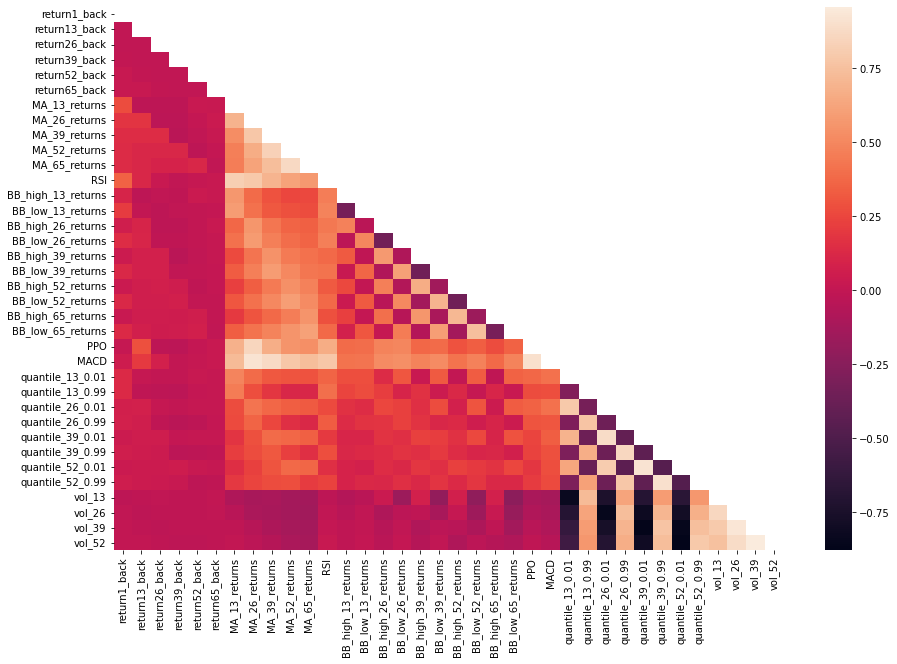

In [28]:
corr = data_train[feature_name].corr(method='pearson')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask = mask)

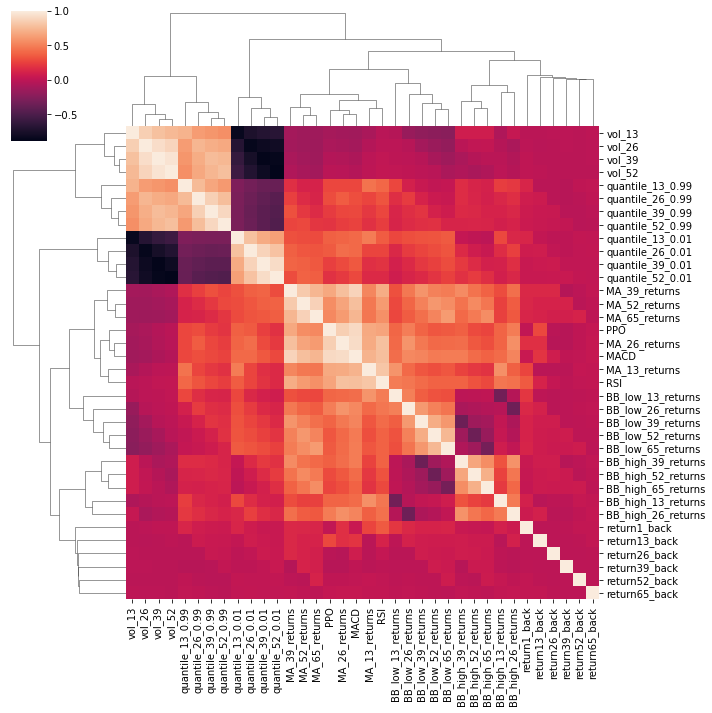

In [29]:
sns.clustermap(data_train[feature_name].corr())

## Pearson Correlation Features vs Target

<AxesSubplot:>

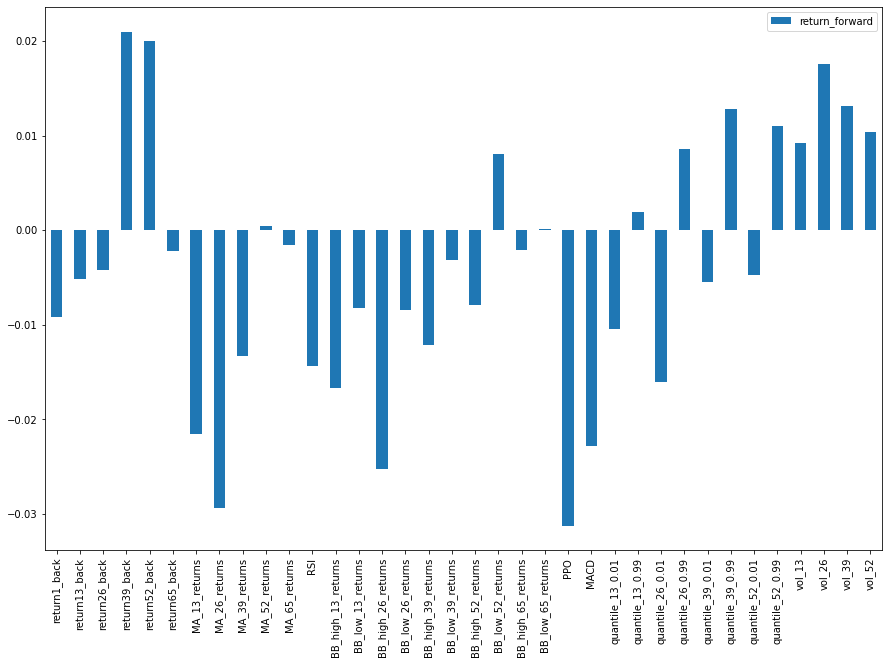

In [30]:
corr = data_train[feature_name + target].corr(method='pearson')
corr[target].iloc[:-1].plot.bar()

In [31]:
data_train[target+feature_name].iloc[:20]

,return_forward,return1_back,return13_back,return26_back,return39_back,return52_back,return65_back,MA_13_returns,MA_26_returns,MA_39_returns,...,quantile_26_0.01,quantile_26_0.99,quantile_39_0.01,quantile_39_0.99,quantile_52_0.01,quantile_52_0.99,vol_13,vol_26,vol_39,vol_52
time,,,,,,,,,,,,,,,,,,,,,
1.660649e+09,-0.000012,-0.000088,-0.000093,-0.000049,-0.000106,-0.000010,-0.000013,-2.628923e-05,-2.689202e-05,-0.000005,...,-0.000157,0.000118,-0.000155,0.000230,-0.000154,0.000229,0.000069,0.000079,0.000092,0.000088
1.660649e+09,-0.000042,0.000063,-0.000018,0.000037,-0.000008,0.000002,0.000044,-2.006084e-05,-2.591860e-05,-0.000003,...,-0.000157,0.000118,-0.000155,0.000230,-0.000154,0.000229,0.000074,0.000080,0.000092,0.000088
1.660649e+09,0.000043,0.000172,-0.000032,-0.000005,0.000001,0.000063,0.000057,-4.376417e-06,-1.911606e-05,0.000001,...,-0.000157,0.000159,-0.000155,0.000230,-0.000154,0.000229,0.000091,0.000089,0.000097,0.000091
1.660649e+09,0.000057,0.000050,-0.000069,-0.000025,0.000232,-0.000034,-0.000057,4.823664e-06,-1.620984e-05,-0.000003,...,-0.000157,0.000159,-0.000155,0.000206,-0.000154,0.000229,0.000090,0.000090,0.000089,0.000091
1.660649e+09,0.000019,0.000028,-0.000055,0.000030,0.000171,-0.000019,0.000043,1.121257e-05,-1.628995e-05,-0.000007,...,-0.000157,0.000159,-0.000155,0.000206,-0.000154,0.000229,0.000088,0.000090,0.000085,0.000091
1.660649e+09,0.000040,-0.000067,0.000059,-0.000002,-0.000030,0.000046,0.000031,1.565270e-06,-1.879763e-05,-0.000008,...,-0.000157,0.000159,-0.000155,0.000206,-0.000154,0.000229,0.000089,0.000091,0.000085,0.000092
1.660649e+09,0.000020,-0.000042,0.000108,-0.000125,0.000008,-0.000044,0.000008,-9.966600e-06,-1.558780e-05,-0.000009,...,-0.000157,0.000159,-0.000155,0.000206,-0.000154,0.000229,0.000084,0.000088,0.000085,0.000092
1.660649e+09,0.000018,0.000085,-0.000042,-0.000143,-0.000005,-0.000059,0.000106,-1.916673e-07,-6.819767e-06,-0.000007,...,-0.000157,0.000159,-0.000155,0.000206,-0.000154,0.000229,0.000087,0.000086,0.000087,0.000092
1.660649e+09,-0.000074,0.000025,0.000019,-0.000111,0.000028,-0.000019,0.000012,2.555564e-07,-1.581175e-06,-0.000007,...,-0.000157,0.000159,-0.000155,0.000206,-0.000154,0.000229,0.000087,0.000084,0.000087,0.000092


## Statistical inference with Linear Regression
**violating mutural colinearity in between features

In [34]:
lr = sm.OLS(data_train[target],data_train[feature_name])
res = lr.fit()

In [35]:
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:         return_forward   R-squared (uncentered):                   0.004
Model:                            OLS   Adj. R-squared (uncentered):              0.002
Method:                 Least Squares   F-statistic:                              1.727
Date:                Tue, 23 Aug 2022   Prob (F-statistic):                     0.00439
Time:                        08:37:35   Log-Likelihood:                      1.1095e+05
No. Observations:               13925   AIC:                                 -2.218e+05
Df Residuals:                   13889   BIC:                                 -2.216e+05
Df Model:                          36                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

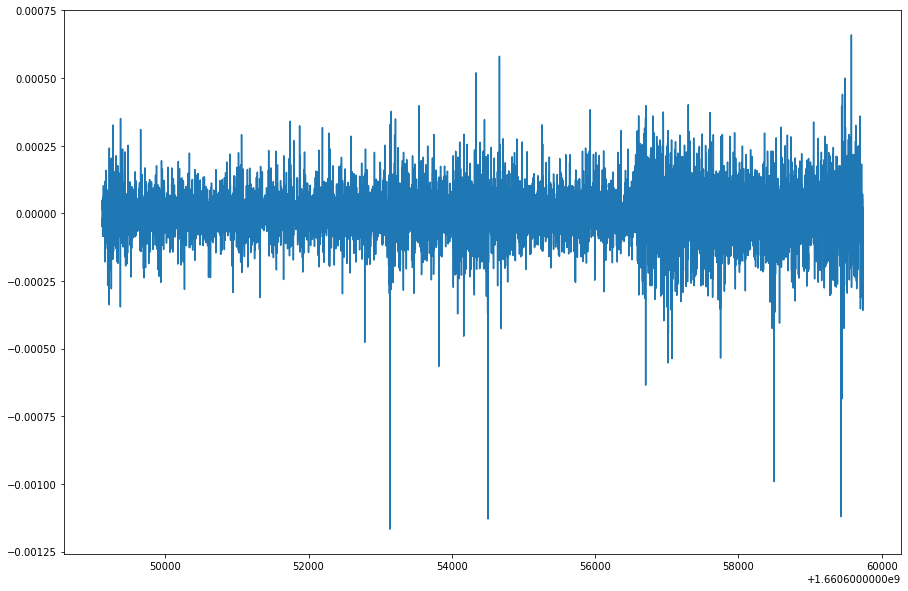

In [36]:
plt.plot(res.resid)

In [64]:
data_train[feature_name]

,return1_back,return13_back,return26_back,return39_back,return52_back,return65_back,MA_13_returns,MA_26_returns,MA_39_returns,MA_52_returns,...,quantile_26_0.01,quantile_26_0.99,quantile_39_0.01,quantile_39_0.99,quantile_52_0.01,quantile_52_0.99,vol_13,vol_26,vol_39,vol_52
time,,,,,,,,,,,,,,,,,,,,,
1.660649e+09,-0.000088,-0.000093,-0.000049,-0.000106,-0.000010,-0.000013,-0.000026,-2.689202e-05,-0.000005,-1.101929e-06,...,-0.000157,0.000118,-0.000155,0.000230,-0.000154,0.000229,0.000069,0.000079,0.000092,0.000088
1.660649e+09,0.000063,-0.000018,0.000037,-0.000008,0.000002,0.000044,-0.000020,-2.591860e-05,-0.000003,7.186500e-08,...,-0.000157,0.000118,-0.000155,0.000230,-0.000154,0.000229,0.000074,0.000080,0.000092,0.000088
1.660649e+09,0.000172,-0.000032,-0.000005,0.000001,0.000063,0.000057,-0.000004,-1.911606e-05,0.000001,2.171920e-06,...,-0.000157,0.000159,-0.000155,0.000230,-0.000154,0.000229,0.000091,0.000089,0.000097,0.000091
1.660649e+09,0.000050,-0.000069,-0.000025,0.000232,-0.000034,-0.000057,0.000005,-1.620984e-05,-0.000003,3.800852e-06,...,-0.000157,0.000159,-0.000155,0.000206,-0.000154,0.000229,0.000090,0.000090,0.000089,0.000091
1.660649e+09,0.000028,-0.000055,0.000030,0.000171,-0.000019,0.000043,0.000011,-1.628995e-05,-0.000007,4.711122e-06,...,-0.000157,0.000159,-0.000155,0.000206,-0.000154,0.000229,0.000088,0.000090,0.000085,0.000091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.660660e+09,-0.000125,-0.000138,-0.000370,0.000088,-0.000065,-0.000026,0.000012,-9.854666e-06,-0.000004,1.295468e-05,...,-0.000284,0.000161,-0.000353,0.000285,-0.000347,0.000297,0.000078,0.000105,0.000121,0.000118
1.660660e+09,0.000062,0.000175,-0.000015,0.000013,0.000092,-0.000013,0.000004,-6.875790e-06,-0.000002,1.238287e-05,...,-0.000284,0.000161,-0.000353,0.000285,-0.000347,0.000297,0.000063,0.000106,0.000122,0.000118
1.660660e+09,0.000017,0.000008,0.000118,0.000028,-0.000020,-0.000013,0.000004,-1.078878e-05,-0.000003,1.309122e-05,...,-0.000284,0.000161,-0.000353,0.000285,-0.000347,0.000297,0.000063,0.000103,0.000122,0.000118


#### Visualisation in lower dimension using PCA

In [32]:
label_up_or_down = data_train["return_forward"].apply(lambda x: "up" if x >0 else "down")
scaled_data = StandardScaler().fit_transform(data_train[feature_name])
pca = PCA(n_components=20)
pca.fit(scaled_data)

PCA(n_components=20)

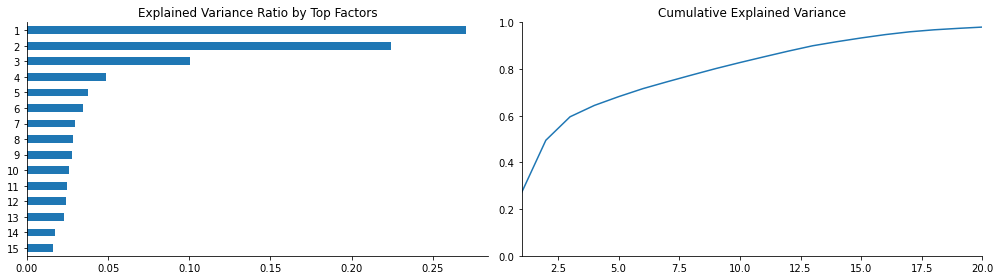

In [35]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
title = 'Explained Variance Ratio by Top Factors'
var_expl = pd.Series(pca.explained_variance_ratio_)
var_expl.index += 1
var_expl.iloc[:15].sort_values().plot.barh(title=title,
                                           ax=axes[0])
var_expl.cumsum().plot(ylim=(0, 1),
                       ax=axes[1],
                       title='Cumulative Explained Variance',
                       xlim=(1, 20))
sns.despine()
fig.tight_layout()

In [41]:
pca_compoments = pd.DataFrame(pca.transform(scaled_data)[:, :10], 
                            columns=[f'Principal Component {i+1}' for i in range(10)], 
                            index=data_train.index)

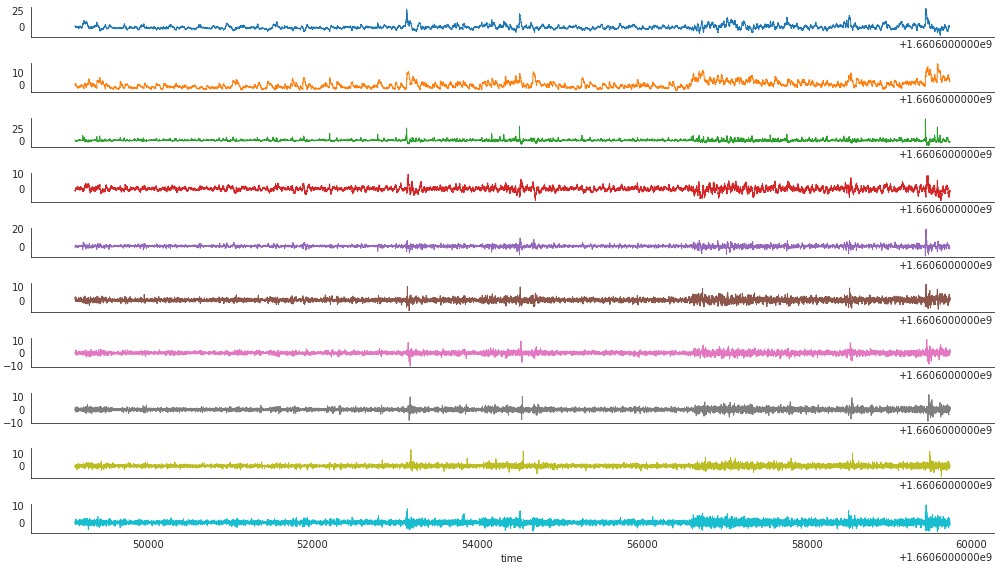

In [42]:
with sns.axes_style('white'):
    pca_compoments.plot(subplots=True,
                      figsize=(14, 8),
                      legend=False,
                      rot=0,
                      lw=1)

    sns.despine()
    plt.tight_layout()

In [43]:
pca_compoments

,Principal Component 1,Principal Component 2,Principal Component 3,Principal Component 4,Principal Component 5,Principal Component 6,Principal Component 7,Principal Component 8,Principal Component 9,Principal Component 10
time,,,,,,,,,,
1.660649e+09,2.249461,-0.906188,1.059631,-1.194248,-2.061183,0.625340,-0.837690,-0.427992,0.529806,0.705359
1.660649e+09,1.710399,-0.605629,-0.154020,-1.517131,-0.519636,1.222076,-0.719321,-0.071769,-0.756564,-0.497079
1.660649e+09,0.690401,0.615912,-1.290025,-0.786131,0.628136,2.053047,-0.093209,-0.411573,-1.172868,-0.837557
1.660649e+09,0.414736,0.538286,-1.244037,-1.131899,0.192969,2.390794,0.905565,1.994726,0.746061,0.012821
1.660649e+09,0.250293,0.550393,-1.618103,-0.961393,0.344035,2.001840,0.404936,1.428978,-0.388796,0.622981
...,...,...,...,...,...,...,...,...,...,...
1.660660e+09,0.614843,3.101580,-3.201697,-0.763363,-0.305191,0.813057,2.628659,2.388020,1.432423,1.697492
1.660660e+09,0.042226,2.914005,-2.738390,-1.748560,-1.648011,0.439665,1.774213,-0.759686,-0.699129,-1.828480
1.660660e+09,0.093515,2.794754,-3.727536,-2.279873,-1.368862,1.341712,-0.156603,-0.076063,-0.242248,-0.331627


<AxesSubplot:xlabel='Principal Component 1', ylabel='Principal Component 2'>

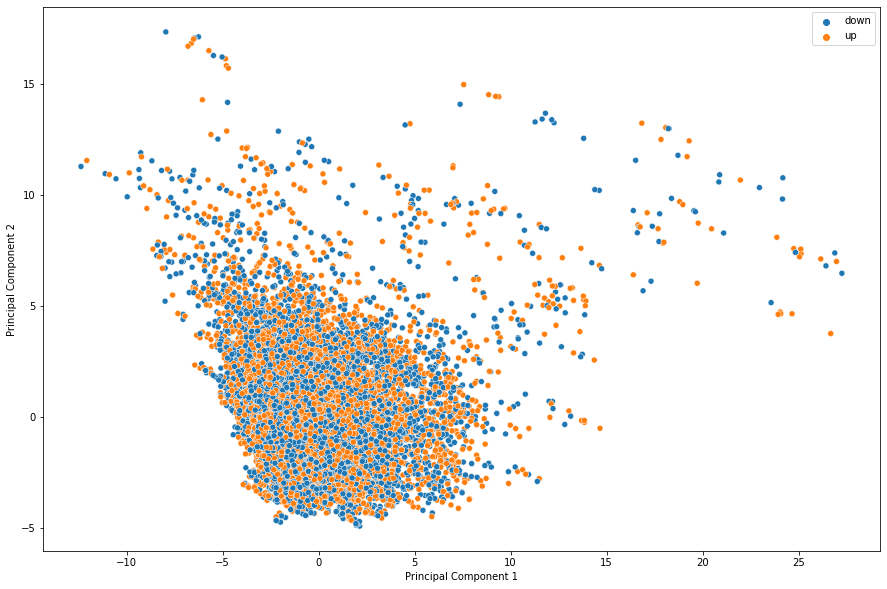

In [44]:
sns.scatterplot(data=pca_compoments, x="Principal Component 1", y="Principal Component 2", hue = label_up_or_down.values)

#### TSNE

In [135]:
X_embedded = TSNE(n_components=2,
                  learning_rate='auto',
                  init='random').fit_transform(data_train[feature_name])


<AxesSubplot:xlabel='First', ylabel='Second'>

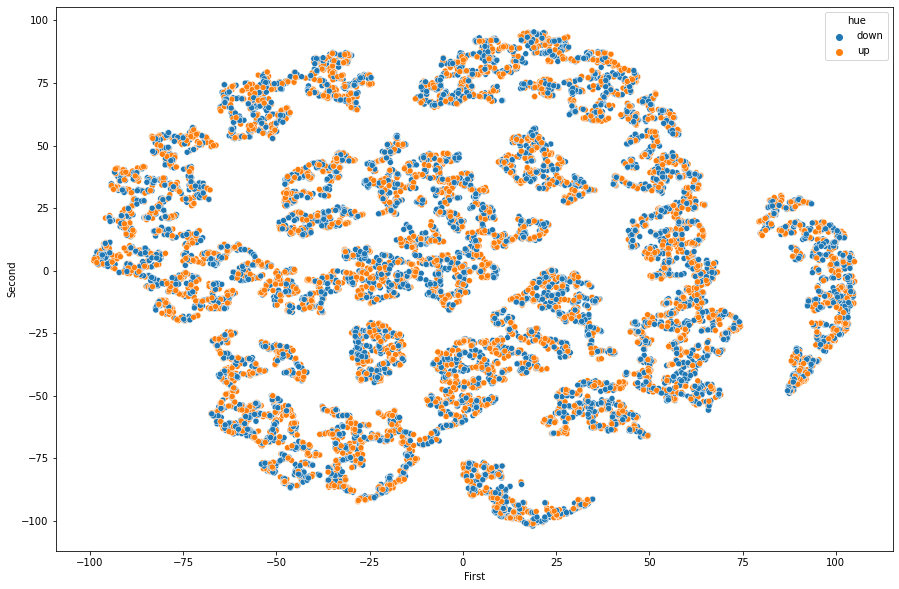

In [152]:
data =pd.DataFrame({"First":X_embedded[:,0],
                    "Second":X_embedded[:,1],
                    "hue":label_up_or_down})
sns.scatterplot(data=data, x="First", y="Second", hue = "hue")

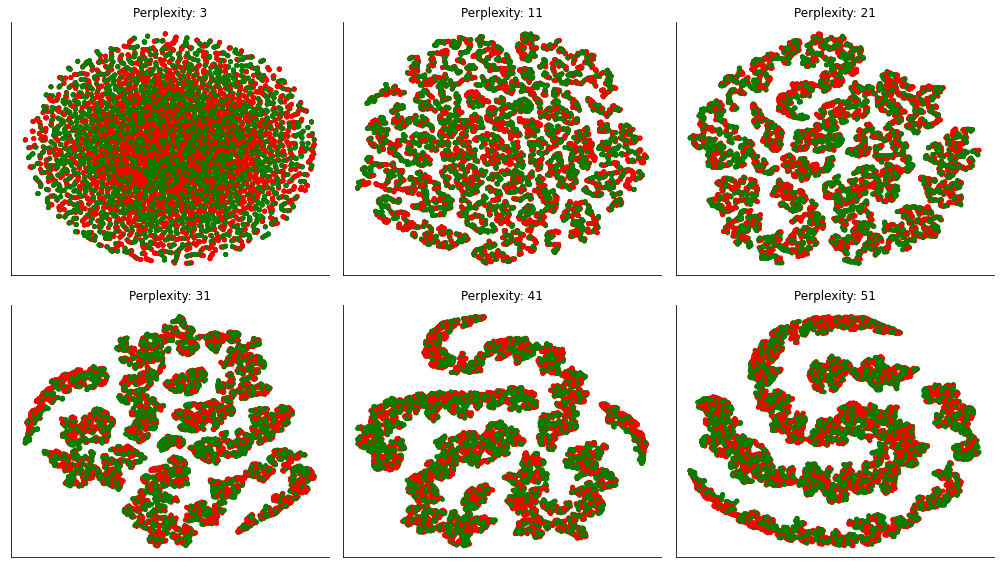

In [163]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 8))
axes = axes.flatten()
colour = pd.Series(lda_compoments).apply(lambda x: "g" if x == "up" else "r")

for i, p in enumerate([3, 11, 21, 31, 41, 51]):
    X_embedded = TSNE(perplexity=p,n_components=2).fit_transform(data_train[feature_name])
    axes[i].scatter(X_embedded[:, 0], X_embedded[:, 1], s=15, c=colour)
    axes[i].set_title(f'Perplexity: {p:.0f}')
    axes[i].axes.get_xaxis().set_visible(False)
    axes[i].axes.get_yaxis().set_visible(False)

sns.despine()
fig.tight_layout();

#### Is it possible to increase liner seperability in between the classes up and down

In [78]:
label_up_or_down.value_counts()/label_up_or_down.shape[0]

down    0.507361
up      0.492639
Name: return_forward, dtype: float64

In [110]:
lda = LinearDiscriminantAnalysis(priors=[0.5,0.5], n_components=1)
lda.fit(data_train[feature_name], label_up_or_down)
lda_compoments = lda.predict(data_train[feature_name])

In [116]:
pd.Series(lda_compoments).value_counts()

down    7456
up      6469
dtype: int64

Text(0.5, 1.0, 'No linear seperability was found')

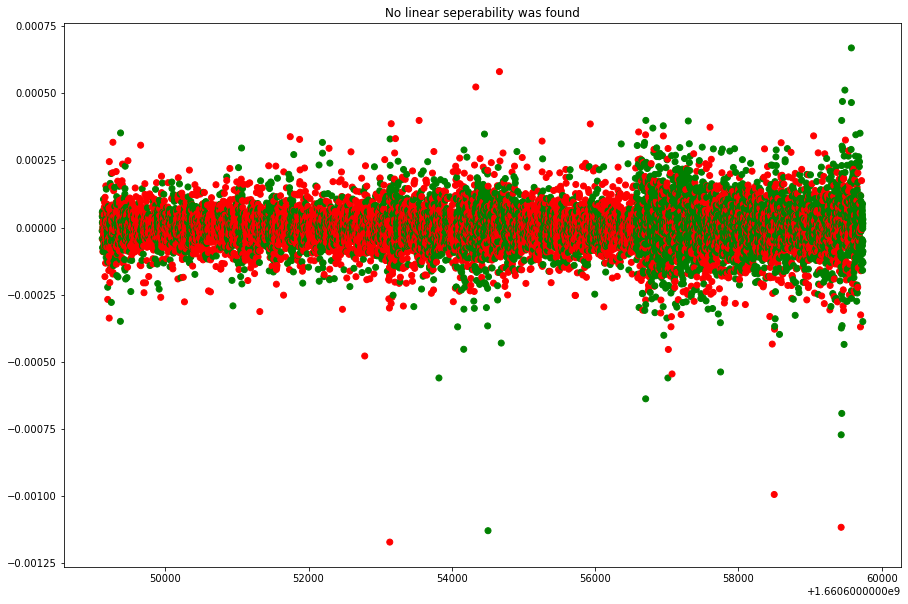

In [126]:
colour = pd.Series(lda_compoments).apply(lambda x: "g" if x == "up" else "r")
plt.scatter(data_train.index,data_train[target], color = colour)
plt.title("No linear seperability was found")

Text(0.5, 1.0, 'Perfet case')

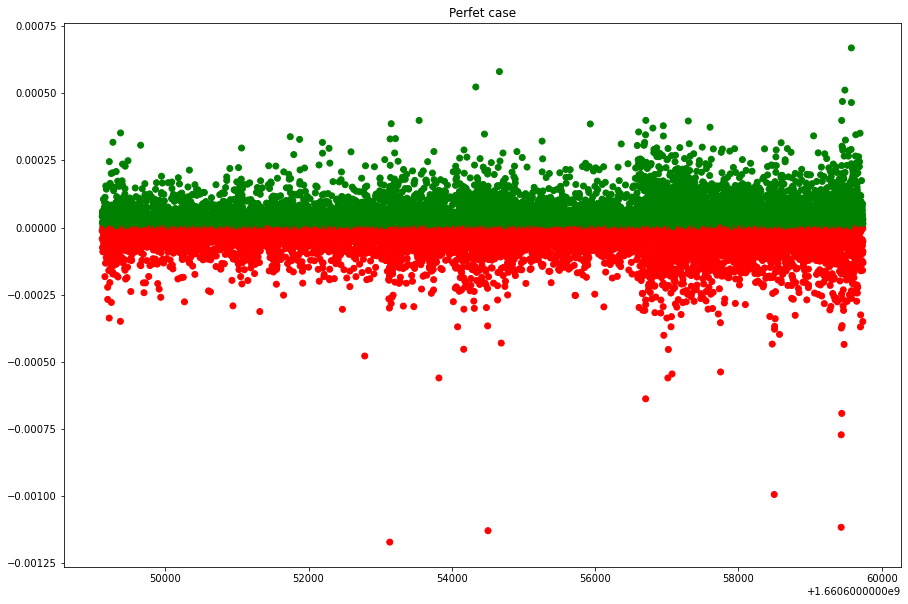

In [125]:
colour = label_up_or_down.apply(lambda x: "g" if x == "up" else "r")
plt.scatter(data_train.index,data_train[target], color = colour)
plt.title("Perfet case")

# Modelling

This Notebook won't focus on hyper paramter tuning, the goal is only to validate the predictable proporteties of the features

## Establish Metric and Baseline Model

In [27]:
# Spearman Correlation will be used as Information Cofficient generated by model as metric
def ic_metric(y_true, y_pred):
    return spearmanr(y_true, y_pred)[0]

In [34]:
def base_line_model_maringale(current_return):
    """
    E[X_(t+1)|F_t]=X_t
    """
    return current_return

In [35]:
print(ic_metric(data_train["return_forward"], base_line_model_maringale(data_train["return"])))

-0.007226426373488548


In [36]:
ic_baseline = []
rolling_window = 100 
start_index = 0
end_index = start_index + rolling_window
while end_index <= data_train.shape[0]:
    y_true = data_train["return_forward"].iloc[start_index:end_index]
    y_pred = base_line_model_maringale(data_train["return"].iloc[start_index:end_index])
    ic_baseline.append(ic_metric(y_true, y_pred))
    start_index+=1
    end_index = start_index + rolling_window

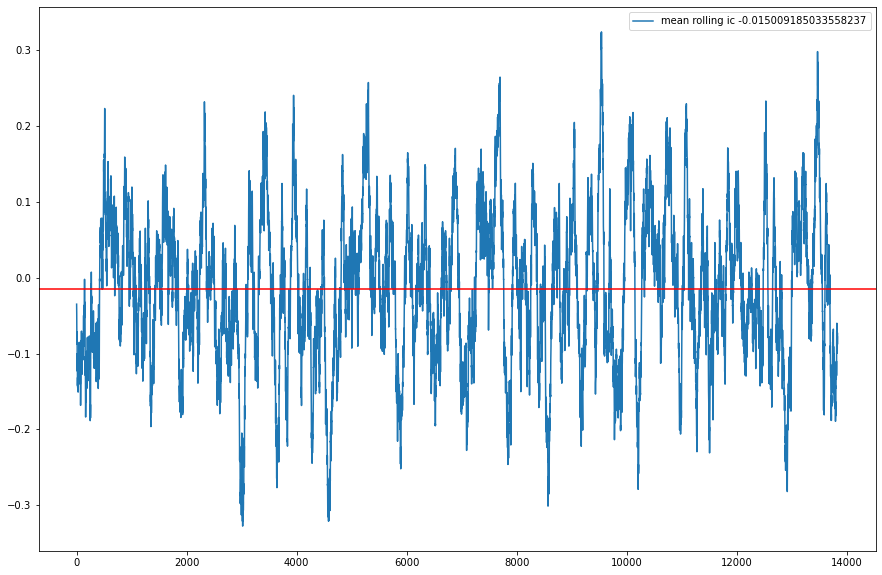

In [37]:
plt.plot(ic_baseline, label = f"mean rolling ic {np.mean(ic_baseline)}")
plt.axhline(np.mean(ic_baseline),c="red")
plt.legend()

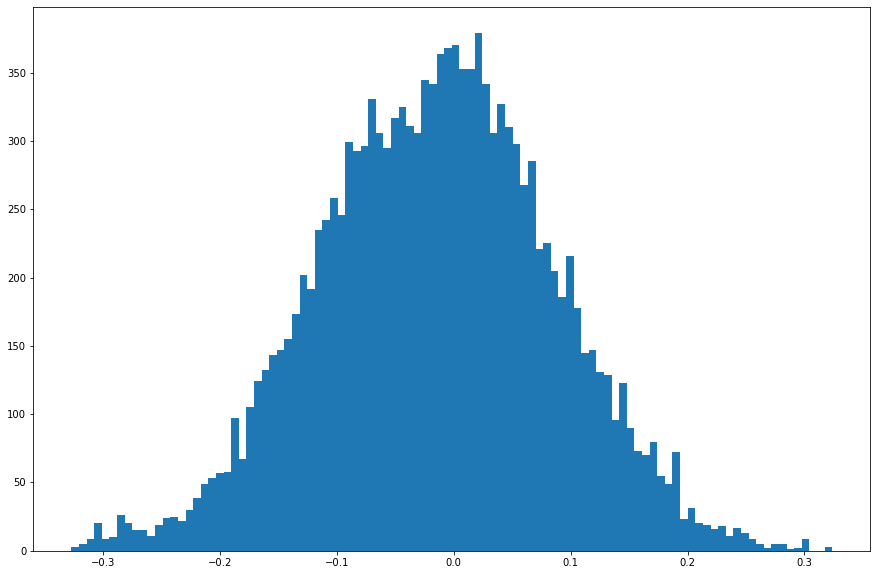

count    13826.000000
mean        -0.015009
std          0.099854
min         -0.327369
25%         -0.083889
50%         -0.012835
75%          0.052058
max          0.323864
dtype: float64


In [38]:
plt.hist(ic_baseline, bins = 100)
plt.show()
print(pd.Series(ic_baseline).describe())

## Random Forest 1 (Rolling)

This implimentation using fixed look back period

In [327]:
train_score = []
val_score = []
look_back_period = 1000 # IS A HYPERPARAMETR which requires tuning
validate_period = 100
start_index = 0
end_index = start_index + look_back_period 
# while end_index <= data_train.shape()[0]:
# won't use all the data just for POC reasons
for i in tqdm.tqdm(range(1000)):
    X_train, y_train = data_train[feature_name].iloc[start_index:end_index], data_train[target].iloc[start_index:end_index]
    X_val, y_val = data_train[feature_name].iloc[end_index:end_index+validate_period], data_train[target].iloc[end_index:end_index+validate_period]
    model = RandomForestRegressor(n_estimators=100,
                                   max_depth=10,
                                   max_features=0.8,
                                   n_jobs=-1)
    model.fit(X_train,y_train)
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    train_score.append(ic_metric(y_train,y_pred_train))
    val_score.append(ic_metric(y_val,y_pred_val))
    start_index=+1 #the lower the value the more time it would require to fit model
    end_index = start_index + look_back_period 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:04<00:00,  4.09it/s]


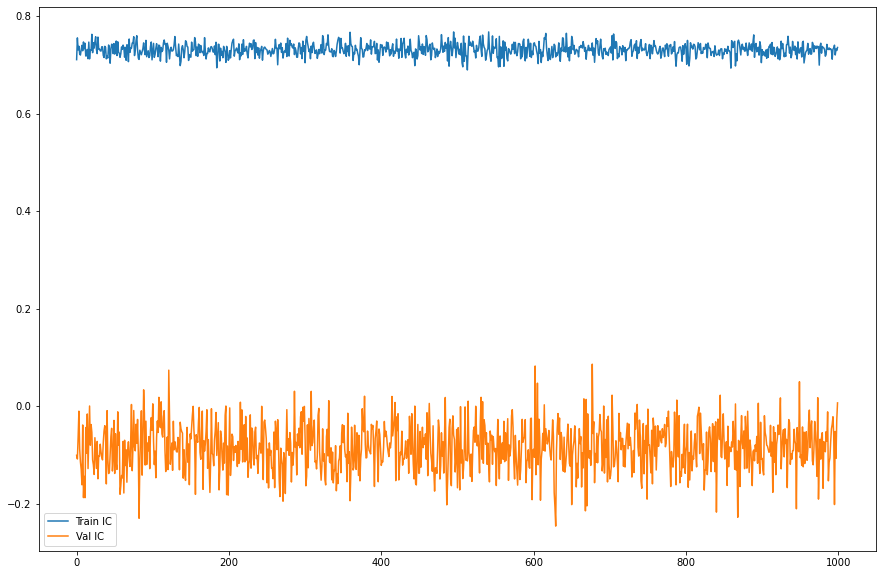

In [332]:
plt.plot(train_score, label="Train IC")
plt.plot(val_score, label="Val IC")
plt.legend()

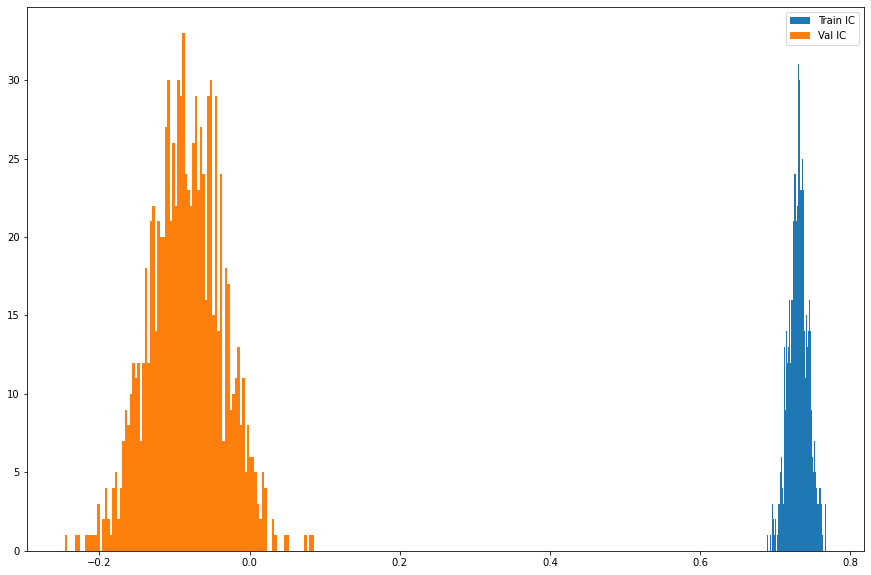

In [333]:
plt.hist(train_score,bins = 100, label="Train IC")
plt.hist(val_score,bins = 100, label="Val IC")
plt.legend()

## Random Forest 2

This implimentation using all avaiable samples at each iteration (from 0 to end_index)

will ading more samples improve the result?

In [343]:
num_observation = []
train_score = []
val_score = []
look_back_period = 1000 # IS A HYPERPARAMETR which requires tuning
validate_period = 100
start_index = 0
end_index = start_index + look_back_period 
# while end_index <= data_train.shape()[0]:
# won't use all the data just for POC reasons
for i in tqdm.tqdm(range(1000)):
    X_train, y_train = data_train[feature_name].iloc[0:end_index], data_train[target].iloc[0:end_index]
    X_val, y_val = data_train[feature_name].iloc[end_index:end_index+validate_period], data_train[target].iloc[end_index:end_index+validate_period]
    model = RandomForestRegressor(n_estimators=100,
                                   max_depth=10,
                                   max_features=0.8,
                                   n_jobs=-1)
    model.fit(X_train,y_train)
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    train_score.append(ic_metric(y_train,y_pred_train))
    val_score.append(ic_metric(y_val,y_pred_val))
    num_observation.append(end_index)
    end_index = end_index + 10 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [16:11<00:00,  1.03it/s]


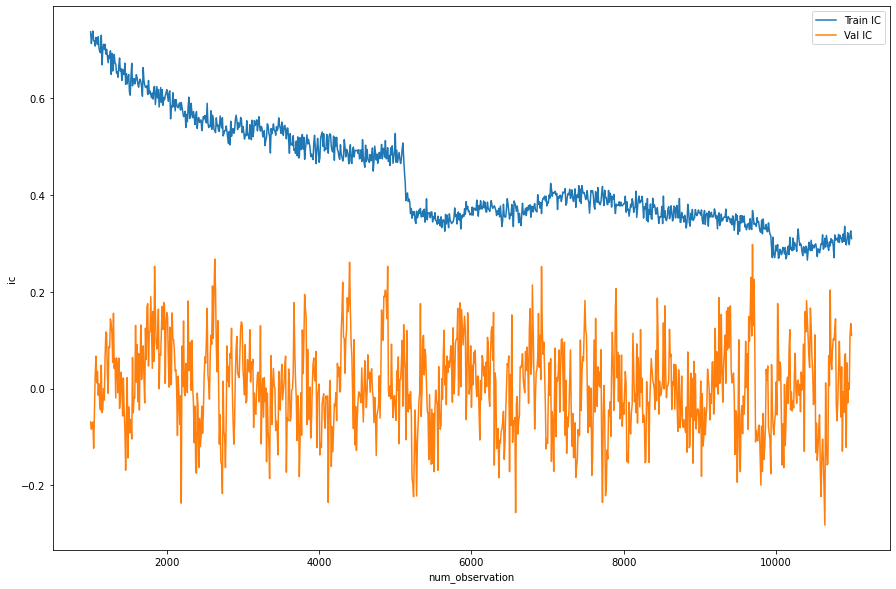

In [351]:
plt.plot(num_observation, train_score, label="Train IC")
plt.plot(num_observation, val_score, label="Val IC")
plt.xlabel("num_observation")
plt.ylabel("ic")
plt.legend()

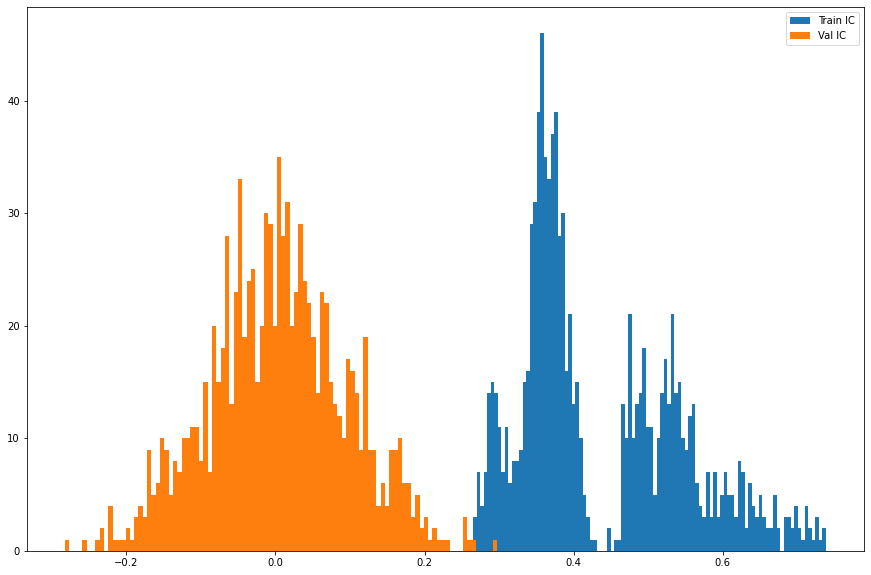

In [345]:
plt.hist(train_score,bins = 100, label="Train IC")
plt.hist(val_score,bins = 100, label="Val IC")
plt.legend()

In [361]:
pd.Series(train_score).describe()

count    1000.000000
mean        0.436075
std         0.109861
min         0.265213
25%         0.354593
50%         0.387953
75%         0.523303
max         0.738241
dtype: float64

In [362]:
pd.Series(val_score).describe()

count    1000.000000
mean        0.003596
std         0.092228
min        -0.282148
25%        -0.056166
50%         0.003243
75%         0.064962
max         0.297618
dtype: float64

<AxesSubplot:xlabel='feature_name'>

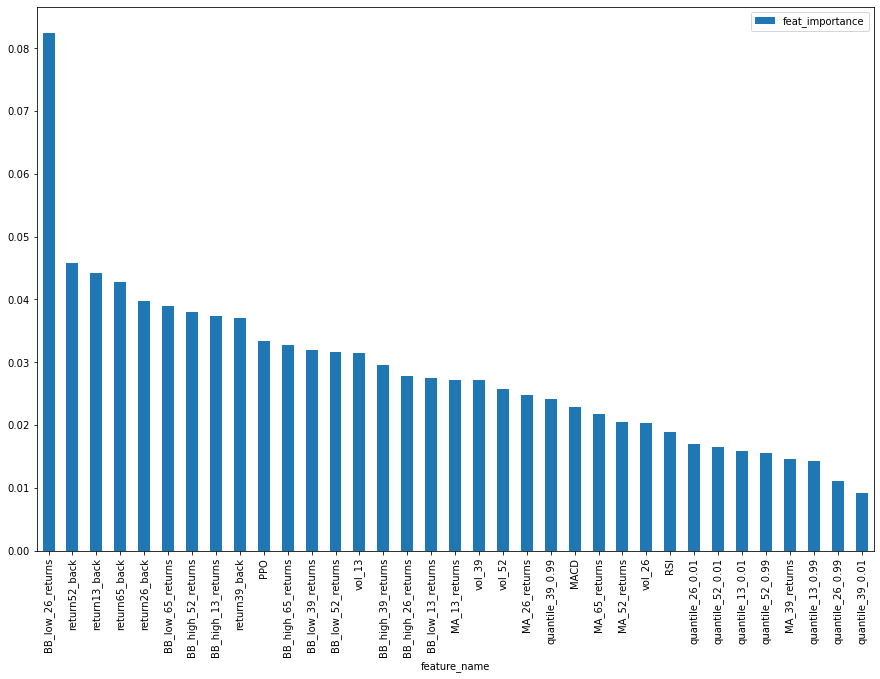

In [360]:
(
    pd.DataFrame({"feat_importance": model.feature_importances_,
                  "feature_name": data_train[feature_name].columns})
    .sort_values(by="feat_importance", ascending=False).plot.bar(x="feature_name", y ="feat_importance")
)

## Boosting

In [45]:
num_observation = []
train_score = []
val_score = []
look_back_period = 1000 # IS A HYPERPARAMETR which requires tuning
validate_period = 100
start_index = 0

params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    'learning_rate': 0.05,
    'verbose': -1
}

end_index = start_index + look_back_period 
# while end_index <= data_train.shape()[0]:
# won't use all the data just for POC reasons
for i in tqdm.tqdm(range(1000)):
    X_train, y_train = data_train[feature_name].iloc[0:end_index], data_train[target].iloc[0:end_index]
    X_val, y_val = data_train[feature_name].iloc[end_index:end_index+validate_period], data_train[target].iloc[end_index:end_index+validate_period]
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=X_train)
    
    model = lgb.train(params=params,
                              train_set=lgb_train,
                              num_boost_round=100,
                              verbose_eval=False)
    
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    train_score.append(ic_metric(y_train,y_pred_train))
    val_score.append(ic_metric(y_val,y_pred_val))
    num_observation.append(end_index)
    end_index = end_index + 10 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:18<00:00,  7.24it/s]


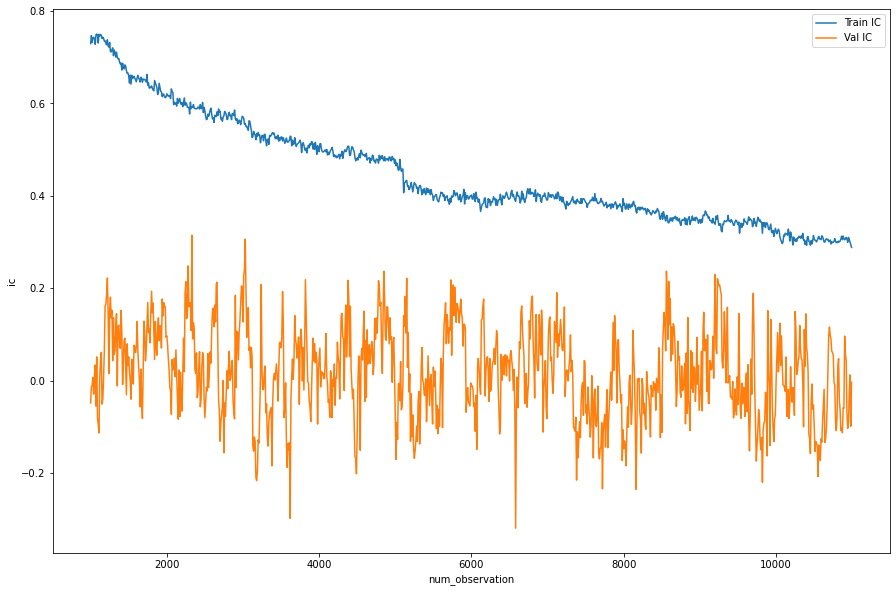

In [46]:
plt.plot(num_observation, train_score, label="Train IC")
plt.plot(num_observation, val_score, label="Val IC")
plt.xlabel("num_observation")
plt.ylabel("ic")
plt.legend()

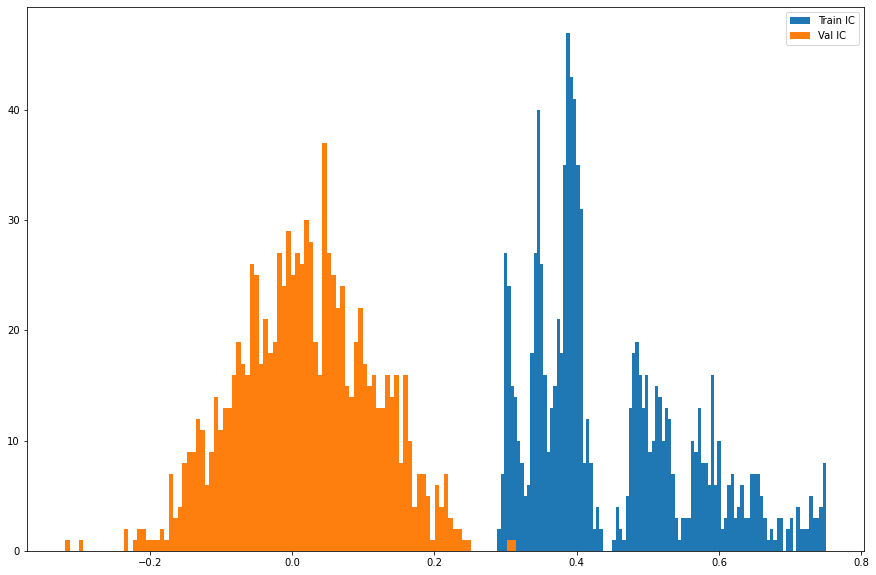

In [47]:
plt.hist(train_score,bins = 100, label="Train IC")
plt.hist(val_score,bins = 100, label="Val IC")
plt.legend()

In [48]:
pd.Series(train_score).describe()

count    1000.000000
mean        0.448102
std         0.114052
min         0.288595
25%         0.360118
50%         0.401582
75%         0.521128
max         0.750408
dtype: float64

In [49]:
pd.Series(val_score).describe()

count    1000.000000
mean        0.017916
std         0.095337
min        -0.319209
25%        -0.049078
50%         0.018789
75%         0.085014
max         0.314923
dtype: float64

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

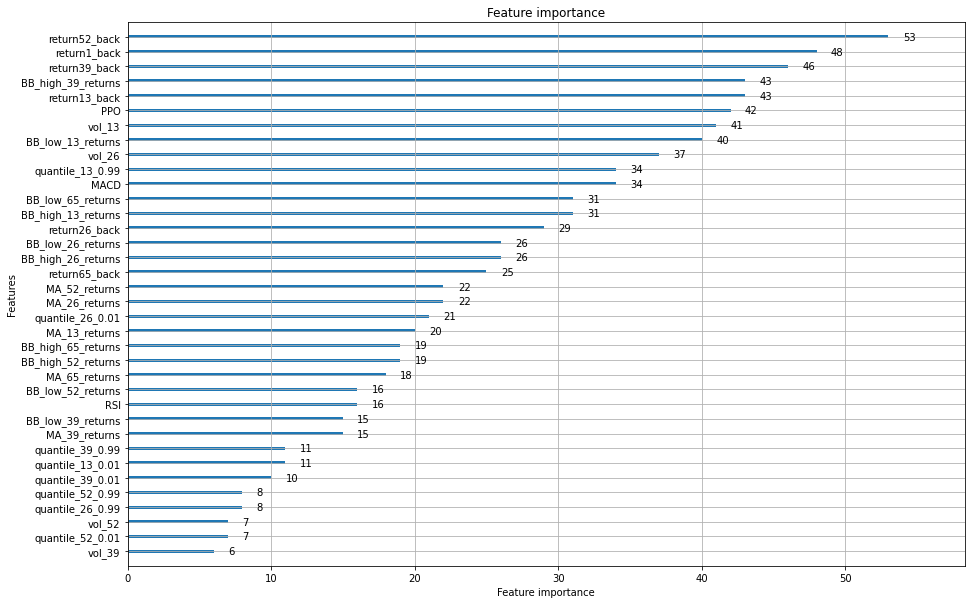

In [50]:
lgb.plot_importance(model)

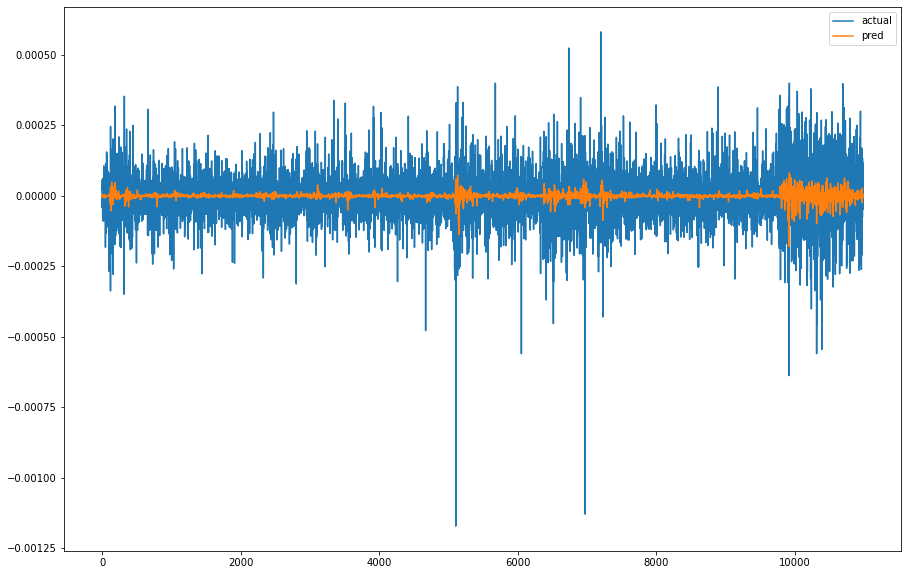

In [55]:
plt.plot(y_train.values, label = "actual")
plt.plot(y_pred_train, label ="pred")
plt.legend()

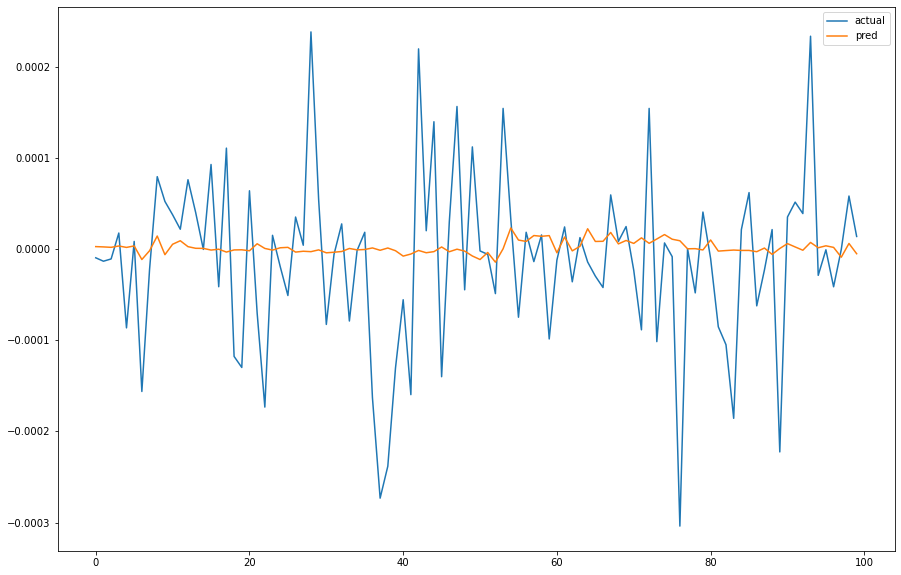

In [56]:
plt.plot(y_val.values, label = "actual")
plt.plot(y_pred_val, label ="pred")
plt.legend()